In [3]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from utils.engine import train_one_epoch, evaluate

## Configure Path

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

DATABASE_BASE = "/home/hemyo/Desktop/1_data/3_Annoatation_data/2_9frame_interval_cropped/YANMAR/"
train_csv_path = DATABASE_BASE + "train.csv"
test_csv_path = DATABASE_BASE + "train.csv"
train_image_path = DATABASE_BASE + "Mark Gatt - Good Quality Transfer – 2021-06-03"
test_image_path = DATABASE_BASE + "Mark Gatt - Good Quality Transfer – 2021-06-03"
model_save_path = "trained_model/gray_preprocessing_test/"
model_save_name = model_save_path + "fasterrcnn_resnet50_fpn"
pretrained_model = "trained_model/cage+gate/v1/fasterrcnn_resnet50_fpn_best.pt"

## Check data

In [5]:
train_csv = pd.read_csv(train_csv_path)
print(train_csv.shape)
train_csv.head()

(108, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,446,0,646,223
1,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,627,204,776,609
2,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,473,391,636,778
3,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,583,653,716,902
4,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,477,975,564,1023


In [6]:
filename_un = train_csv["filename"].unique()
print(len(filename_un))

33


In [4]:
test_csv = pd.read_csv(test_csv_path)
print(test_csv.shape)
test_csv.head()

(108, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,446,0,646,223
1,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,627,204,776,609
2,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,473,391,636,778
3,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,583,653,716,902
4,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,tuna_whole,477,975,564,1023


In [5]:
categories = train_csv["class"].unique()
print(categories)

['tuna_whole']


## Encoding classes to integers
* 0 is for background

In [6]:
# Encoding functions
class LabelMap:
    def __init__(self, categories):
        self.map_dict = {}
        self.reverse_map_dict={}
        for i, cat in enumerate(categories):
            self.map_dict[cat] = i + 1
            self.reverse_map_dict[i] = cat
    def fit(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df
    def inverse(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df

In [7]:
label_map = LabelMap(categories)

In [8]:
train_csv = label_map.fit(train_csv, "class")
train_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,446,0,646,223
1,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,627,204,776,609
2,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,473,391,636,778
3,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,583,653,716,902
4,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,477,975,564,1023


In [9]:
test_csv = label_map.fit(test_csv, "class")
test_csv.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,446,0,646,223
1,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,627,204,776,609
2,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,473,391,636,778
3,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,583,653,716,902
4,20210603_104900992_220307_MLT-2021-AUT-CG-001-...,1360,1024,1,477,975,564,1023


## Torch Dataset Creation

In [10]:
class AnimalDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_path, categories, transforms=None,**kwargs):
        super().__init__(**kwargs)
        self.df = df
        self.image_path = image_path
        self.categories = categories
        self.images = self.df["filename"].unique()
        self.transforms = transforms
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_file = os.path.join(self.image_path, self.images[idx])
        img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0
        image_data = self.df[self.df['filename'] == self.images[idx]]
        labels = torch.as_tensor(image_data["class"].values, dtype=torch.int64)
        xmins = image_data["xmin"].values
        ymins = image_data["ymin"].values
        xmaxs = image_data["xmax"].values
        ymaxs = image_data["ymax"].values
        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)
        areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img = transformed["image"]
            target["boxes"] = torch.as_tensor(transformed["bboxes"],dtype=torch.float32)
        return torch.as_tensor(img, dtype=torch.float32), target
    def get_height_and_width(self, image):
        image_data = self.df.loc[self.df['filename'] == image]
        return image_data["width"].values[0], image_data["height"].values[0]

## Data Augmentation

In [11]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # A.ISONoise(p=0.2),
    # A.GaussNoise(p=0.2),
    # A.CLAHE(p=0.1),
    # A.CenterCrop(height=700, width=1000, p=0.3),
    # A.HueSaturationValue(p=0.1),
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [12]:
transform_test = A.Compose([
    ToTensorV2(p=1)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

## Dataloader creation

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
train_dataset = AnimalDataset(train_csv, train_image_path, categories, transform_train)
test_dataset = AnimalDataset(test_csv, test_image_path, categories, transform_test)

In [15]:
data_loader_train = torch.utils.data.DataLoader(
        train_dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=collate_fn)
    
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

## Plot images from dataloader

In [16]:
def plot_images(images, targets):
    for image, target in zip(images, targets):
        sample = image.permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        boxes = target["boxes"].cpu().numpy().astype(np.int32)
        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)
        ax.set_axis_off()
        ax.imshow(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train batch


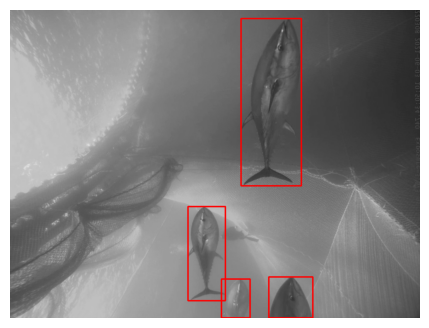

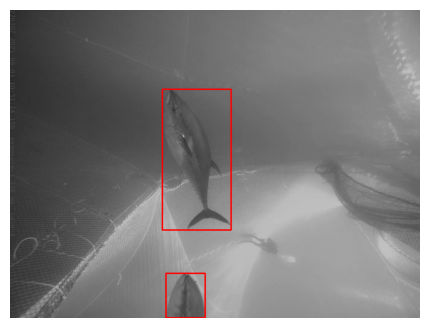

In [17]:
images, targets = next(iter(data_loader_train))
print("Train batch")
plot_images(images, targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test batch


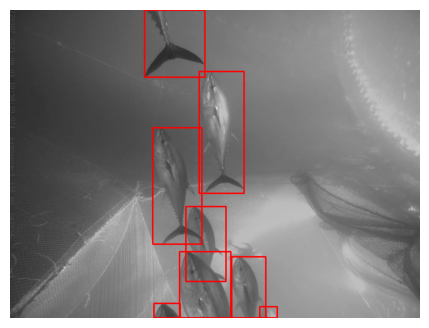

In [18]:
images, targets = next(iter(data_loader_test))
print("test batch")
plot_images(images, targets)

## Training

import model from torchvision library </br>
https://pytorch.org/vision/0.11/models.html

In [19]:
num_classes = len(categories)+1 # add background class

In [20]:
import torchvision.models.detection as torch_det

detection_model = torch_det.fasterrcnn_resnet50_fpn(pretrained=True)

# ... Alternatives ...
# detection_model = torch_det.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
# detection_model = torch_det.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# detection_model = torch_det.ssdlite320_mobilenet_v3_large(num_classes=num_classes)
# detection_model = torch_det.ssd300_vgg16(num_classes=num_classes)
# detection_model = torch_det.retinanet_resnet50_fpn(num_classes=num_classes)

/home/hemyo/anaconda3/envs/env1/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/hemyo/anaconda3/envs/env1/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


adjust classes

In [21]:
# for FastRCNN series... 
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features
detection_model.roi_heads.box_predictor = torch_det.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

GPU load try and mount the model

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
# if you have pre-trianed model
detection_model.load_state_dict(torch.load(pretrained_model))

detection_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Training and validation config

In [24]:
def training(model, train_loader, val_loader, epochs=10, patience=50):
    # init valiables
    cur_patience = patience
    min_loss = float('inf')
    
    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    for epoch in range(epochs):
        # train for one epoch, printing every 10 iterations
        train_result = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=120)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, val_loader, device=device)

        # early stopping function
        cur_loss = float(str(train_result.meters['loss']).split()[0])

        if cur_loss < min_loss : 
            min_loss = cur_loss # update min loss
            torch.save(detection_model.state_dict(), model_save_name+'_best.pt') # save the best model
            cur_patience = patience # reset patience
            print("reset patience, saved mode")
        else :
            cur_patience -= 1
            print("current patience:",cur_patience, "current loss: ",cur_loss, "best loss: ", min_loss)

        if cur_patience == 0 : # reach early stop
            print("early stop at epoch {} due to no loss improve for {} epochs".format(epoch,patience))
            break

In [25]:
# Create directory if not exist
os.makedirs(model_save_path, exist_ok=True)

# start training
training(detection_model, data_loader_train, data_loader_test, epochs=10 )

Epoch: [0]  [ 0/17]  eta: 0:00:34  lr: 0.000063  loss: 0.2920 (0.2920)  loss_classifier: 0.1513 (0.1513)  loss_box_reg: 0.1268 (0.1268)  loss_objectness: 0.0098 (0.0098)  loss_rpn_box_reg: 0.0041 (0.0041)  time: 2.0160  data: 0.2011  max mem: 2140
Epoch: [0]  [16/17]  eta: 0:00:00  lr: 0.001000  loss: 0.1884 (0.2113)  loss_classifier: 0.0831 (0.0953)  loss_box_reg: 0.1110 (0.1039)  loss_objectness: 0.0039 (0.0083)  loss_rpn_box_reg: 0.0036 (0.0038)  time: 0.5988  data: 0.0153  max mem: 2408
Epoch: [0] Total time: 0:00:10 (0.6002 s / it)
creating index...
index created!
Test:  [ 0/33]  eta: 0:00:08  model_time: 0.1245 (0.1245)  evaluator_time: 0.0025 (0.0025)  time: 0.2472  data: 0.1178  max mem: 2408
Test:  [32/33]  eta: 0:00:00  model_time: 0.1166 (0.1163)  evaluator_time: 0.0007 (0.0010)  time: 0.1223  data: 0.0022  max mem: 2408
Test: Total time: 0:00:04 (0.1264 s / it)
Averaged stats: model_time: 0.1166 (0.1163)  evaluator_time: 0.0007 (0.0010)
Accumulating evaluation results...
DO

## SAVE MODEL

In [59]:
# Save model (parameters only)
torch.save(detection_model.state_dict(), model_save_name+'_v1.pt')